In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

import os
import math
import random
import shutil
import cv2
import imghdr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy
from scipy import ndimage

In [4]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
#minimise gpu limit consumption growth
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [46]:
BASE_DIR = 'data/'
names = ["angry", "happy", "sad"]
tf.random.set_seed(1)
img_exts = ['jpeg','jpg','bmp','png']

In [5]:
#check images
for image_class in os.listdir(BASE_DIR): 
    for image in os.listdir(os.path.join(BASE_DIR, image_class)):
        image_path = os.path.join(BASE_DIR, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            #os.remove(image_path)

Issue with image data/test\angry
Issue with image data/test\happy
Issue with image data/test\sad
Issue with image data/train\angry
Issue with image data/train\happy
Issue with image data/train\sad
Issue with image data/val\angry
Issue with image data/val\happy
Issue with image data/val\sad


In [6]:
#img = cv2.imread(os.path.join(data_dir,'sad','8iAb9k4aT.jpg'))
#img.shape
#plt.imshow(img)

In [7]:
#reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [8]:
# Re-arrange the image files
orig_folders = ["angry/", "happy/", "sad/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/angry/'

In [11]:
# Generate batches of tensor image data with
# optional real-time data augmentation.

# preprocessing_function
# rescale=1./255 -> [0,1]
train_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'data/train',
    target_size=(256, 256),
    #use sparce if using SparseCategoricalCrossentropy
    #class_mode='sparse',
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'data/val',
    target_size=(256, 256),
    #class_mode='sparse',
    class_mode='categorical',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'data/test',
    target_size=(256, 256),
    #class_mode='sparse',
    class_mode='categorical',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 335 images belonging to 3 classes.
Found 140 images belonging to 3 classes.
Found 83 images belonging to 3 classes.


In [7]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
val_batch = val_batches[0]
print(val_batch[0].shape)
print(val_batch[1])
test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[0. 1. 0. 1.]
(4, 256, 256, 3)
[0. 0. 0. 0.]
(4, 256, 256, 3)
[0. 0. 0. 0.]


In [72]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            #lbl += "/ Pred:" + names[int(pred_labels[i])]
            lbl += "/ Pred:" + names[pred_labels[i]]
        plt.xlabel(lbl)
    plt.show()

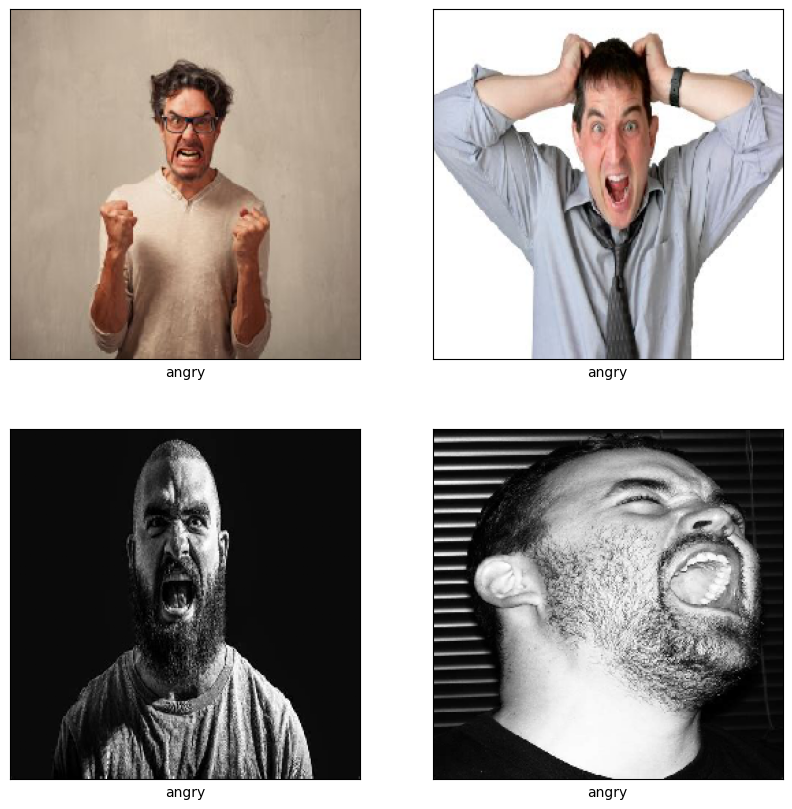

In [73]:
show(test_batch)

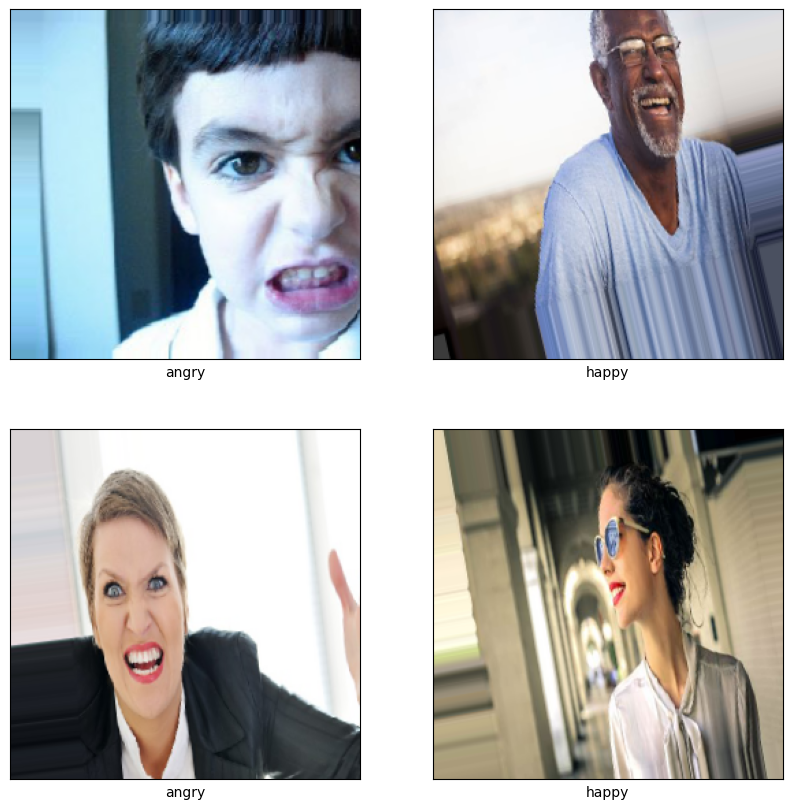

In [26]:
show(train_batch)

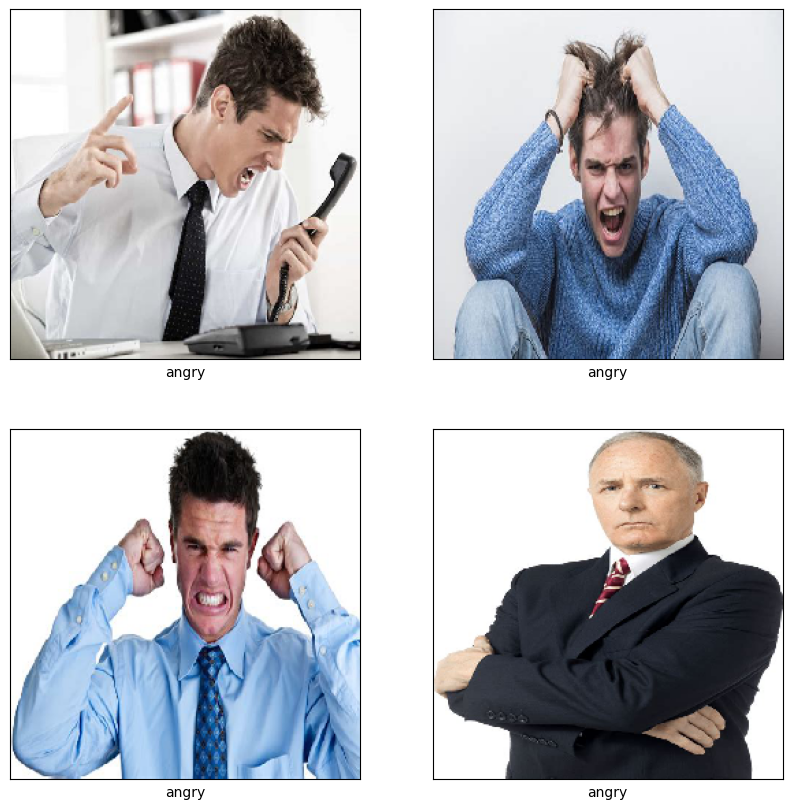

In [27]:
show(val_batch)

In [12]:
#build model
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
#model.add(layers.Dense(5))
print(model.summary())

##past_model
#model = Sequential()
##conv2d params(filter_size,shape_of_filter,stride)
##input_shape from tf.keras.utils.image_dataset_from_directory('data')
##which converts image to 256x256
#model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#model.add(MaxPooling2D())

#shape gets halved every layer
#model.add(Conv2D(32, (3,3), 1, activation='relu'))
#model.add(MaxPooling2D())

#model.add(Conv2D(16, (3,3), 1, activation='relu'))
#model.add(MaxPooling2D())

#model.add(Flatten())

##fully connected layers
#model.add(Dense(256, activation='relu'))
##single output either 0 or 1
#model.add(Dense(1, activation='sigmoid'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [13]:
# loss and optimizer
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = keras.losses.CategoricalCrossentropy()
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [14]:
# training
epochs = 20

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data=val_batches,
                    callbacks=[early_stopping],
                    epochs=epochs, verbose=2)

Epoch 1/20


D:\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


84/84 - 34s - loss: 1.5875 - accuracy: 0.3731 - val_loss: 1.0078 - val_accuracy: 0.4643 - 34s/epoch - 403ms/step
Epoch 2/20
84/84 - 9s - loss: 1.0307 - accuracy: 0.4776 - val_loss: 0.9222 - val_accuracy: 0.5786 - 9s/epoch - 108ms/step
Epoch 3/20
84/84 - 9s - loss: 0.9940 - accuracy: 0.5463 - val_loss: 0.8894 - val_accuracy: 0.5714 - 9s/epoch - 109ms/step
Epoch 4/20
84/84 - 9s - loss: 0.9790 - accuracy: 0.5761 - val_loss: 0.9157 - val_accuracy: 0.5286 - 9s/epoch - 107ms/step
Epoch 5/20
84/84 - 9s - loss: 0.9566 - accuracy: 0.5522 - val_loss: 0.8788 - val_accuracy: 0.6071 - 9s/epoch - 107ms/step
Epoch 6/20
84/84 - 9s - loss: 0.9794 - accuracy: 0.5313 - val_loss: 0.8656 - val_accuracy: 0.6071 - 9s/epoch - 108ms/step
Epoch 7/20
84/84 - 10s - loss: 0.9553 - accuracy: 0.5761 - val_loss: 0.8572 - val_accuracy: 0.6286 - 10s/epoch - 124ms/step
Epoch 8/20
84/84 - 10s - loss: 0.9353 - accuracy: 0.5881 - val_loss: 0.8632 - val_accuracy: 0.6357 - 10s/epoch - 118ms/step
Epoch 9/20
84/84 - 9s - loss:

In [66]:
score = model.evaluate(val_batches)
print(f'Test accuracy: {score[1] * 100} %')

35/35 [==============================] - 1s 15ms/step - loss: 0.8390 - accuracy: 0.6500
Test accuracy: 64.99999761581421 %


In [16]:
model.save("angry_happy_sad_model.h5")

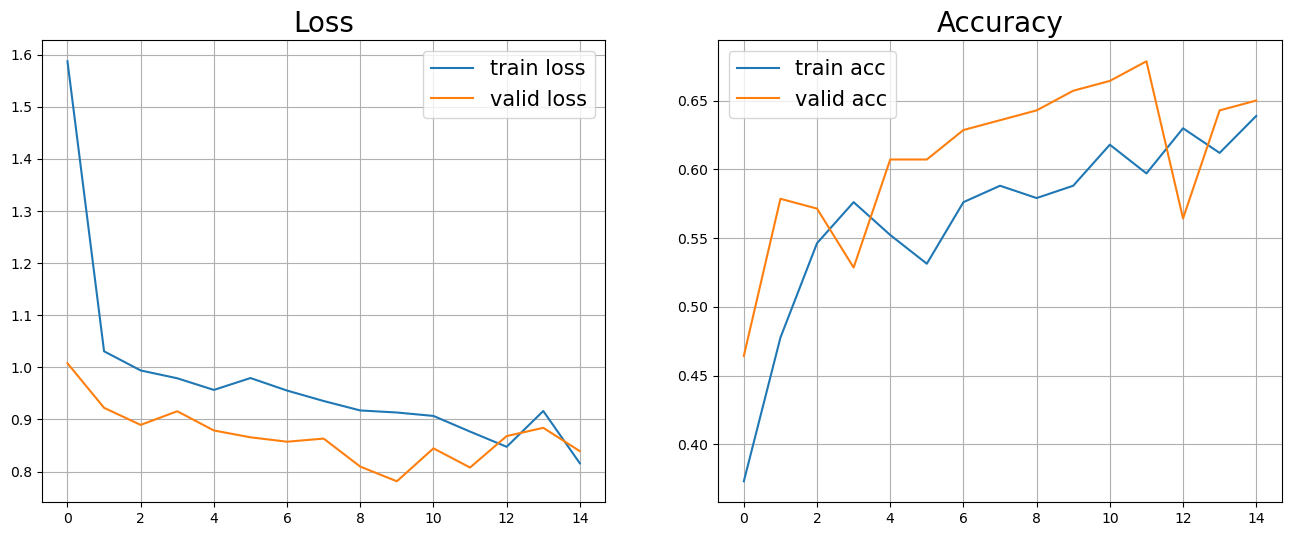

In [15]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.title('Loss', fontsize=20)
plt.legend(fontsize=15)


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.title('Accuracy', fontsize=20)
plt.legend(fontsize=15);

In [ ]:
#graph depicts overfitting june 4, 2023

In [17]:
# evaluate on test data
model.evaluate(test_batches, verbose=2)

21/21 - 2s - loss: 0.6497 - accuracy: 0.7590 - 2s/epoch - 100ms/step


[0.6496989130973816, 0.759036123752594]

In [19]:
# make some predictions
predictions = model.predict(test_batches)
print(predictions)
#predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)
print(labels)

21/21 [==============================] - 1s 60ms/step
[[4.41168457e-01 4.18206751e-01 1.40624821e-01]
 [7.21694708e-01 2.59421557e-01 1.88837200e-02]
 [3.11051589e-02 7.67977387e-02 8.92097056e-01]
 [8.03706348e-02 9.03972507e-01 1.56568680e-02]
 [6.59219325e-01 2.08856761e-01 1.31923899e-01]
 [6.43548667e-01 3.39817166e-01 1.66341886e-02]
 [8.39859068e-01 1.14856869e-01 4.52840589e-02]
 [5.19091249e-01 4.10318583e-01 7.05901980e-02]
 [3.15788746e-01 3.59915584e-01 3.24295640e-01]
 [7.54843533e-01 1.97993666e-01 4.71628085e-02]
 [5.56229949e-01 3.32360834e-01 1.11409202e-01]
 [5.26488006e-01 4.68028188e-01 5.48376888e-03]
 [5.94198048e-01 3.94142359e-01 1.16596445e-02]
 [1.26236007e-01 4.88707304e-01 3.85056704e-01]
 [7.99571514e-01 1.72373891e-01 2.80545130e-02]
 [4.01611149e-01 2.95836210e-01 3.02552611e-01]
 [5.81155360e-01 3.60913903e-01 5.79307936e-02]
 [7.11822689e-01 2.70909131e-01 1.72681827e-02]
 [5.95139265e-01 3.16319376e-01 8.85413736e-02]
 [3.70829105e-01 5.66226423e-01 6.

In [29]:
import matplotlib.image as mpimg

(768, 1024, 3)

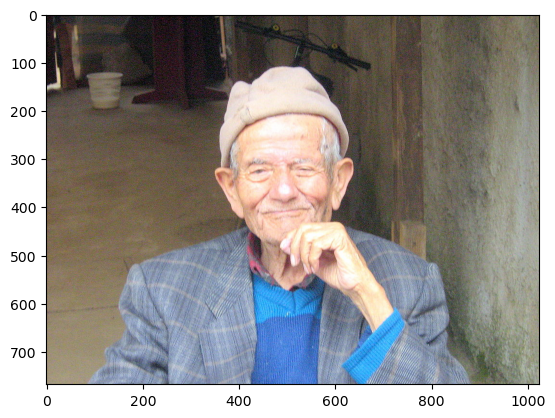

In [30]:
my_image = mpimg.imread('happyTest.jpg')
plt.imshow(my_image)
my_image.shape

In [31]:
my_image = tf.io.read_file('happyTest.jpg')
my_image = tf.image.decode_image(my_image)
my_image = tf.image.resize(my_image,size=[256,256])
my_image = my_image / 255
my_image

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.18235295, 0.07843138, 0.0627451 ],
        [0.12156863, 0.05882353, 0.11176471],
        [0.1764706 , 0.16666667, 0.18039216],
        ...,
        [0.44117647, 0.4137255 , 0.33333334],
        [0.41960785, 0.37254903, 0.3       ],
        [0.5       , 0.4490196 , 0.3509804 ]],

       [[0.07450981, 0.11960784, 0.01764706],
        [0.08431373, 0.06862745, 0.09411765],
        [0.0882353 , 0.03137255, 0.09607843],
        ...,
        [0.44117647, 0.42941177, 0.33137256],
        [0.41960785, 0.4       , 0.2784314 ],
        [0.46078432, 0.42941177, 0.3392157 ]],

       [[0.22941177, 0.10392157, 0.15882353],
        [0.13529412, 0.01764706, 0.09803922],
        [0.1392157 , 0.06666667, 0.10196079],
        ...,
        [0.4862745 , 0.44509804, 0.3882353 ],
        [0.4254902 , 0.3627451 , 0.3392157 ],
        [0.4745098 , 0.40980393, 0.3529412 ]],

       ...,

       [[0.62352943, 0.6019608 , 0.41960785],
        [0.64

In [104]:
my_predict = model.predict(tf.expand_dims(my_image,axis=0))
my_predict

1/1 [==============================] - 0s 16ms/step


array([[0.3066806 , 0.5855117 , 0.10780771]], dtype=float32)

In [105]:
#np.argmax(my_predict)
predicted_name = names[np.argmax(my_predict)]
predicted_name

'happy'

In [26]:
# convert keras model to tflite 
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

model =tf.keras.models.load_model("angry_happy_sad_model.h5")

#Convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#Implement optimization strategy for smaller model sizes
#converter.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size
tflite_model = converter.convert()
open("angry_happy_sad_model.tflite", "wb").write(tflite_model)
convert_bytes(get_file_size("angry_happy_sad_model.tflite"), "KB")

INFO:tensorflow:Assets written to: C:\Users\MIXYES~1\AppData\Local\Temp\tmpq_dhwd60\assets


INFO:tensorflow:Assets written to: C:\Users\MIXYES~1\AppData\Local\Temp\tmpq_dhwd60\assets


File size: 61584.164 Kilobytes


In [27]:
interpreter = tf.lite.Interpreter(model_path = "angry_happy_sad_model.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 256 256   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 3]
Output Type: <class 'numpy.float32'>


In [52]:
from time import time

tflite_model_path = "angry_happy_sad_model.tflite"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on input data.
input_shape = input_details[0]['shape']
print(input_shape)

# Load image
input_data = my_image
input_data = np.expand_dims(input_data, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data)

time_before=time()
interpreter.invoke()
time_after=time()
total_tflite_time = time_after - time_before
print("Total prediction time for tflite model is: ", total_tflite_time)

output_data_tflite = interpreter.get_tensor(output_details[0]['index'])
print("The tflite prediction for this image is: ", output_data_tflite, 'or',names[np.argmax(output_data_tflite)])
print(output_data_tflite[0][0])
print(output_data_tflite[0][1])
print(output_data_tflite[0][2])
print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(names[np.argmax(output_data_tflite)], 100 * np.max(output_data_tflite)))

[  1 256 256   3]
Total prediction time for tflite model is:  0.026000261306762695
The tflite prediction for this image is:  [[0.3066807  0.58551157 0.10780772]] or happy
0.3066807
0.58551157
0.10780772
This image most likely belongs to happy with a 58.55 percent confidence.
